In [25]:
import pandas as pd                                       # dataframes y utilidades
from datetime import timedelta                            # diferencia entre datos tipo tiempo
from oandapyV20 import API                                # conexion con broker OANDA
import oandapyV20.endpoints.instruments as instruments    # informacion de precios historicos

In [26]:
def f_precios_masivos(p0_fini, p1_ffin, p2_gran, p3_inst, p4_oatk, p5_ginc):
    """
    Parameters
    ----------
    p0_fini
    p1_ffin
    p2_gran
    p3_inst
    p4_oatk
    p5_ginc
    Returns
    -------
    dc_precios
    Debugging
    ---------
    """

    def f_datetime_range_fx(p0_start, p1_end, p2_inc, p3_delta):
        """
        Parameters
        ----------
        p0_start
        p1_end
        p2_inc
        p3_delta
        Returns
        -------
        ls_resultado
        Debugging
        ---------
        """

        ls_result = []
        nxt = p0_start

        while nxt <= p1_end:
            ls_result.append(nxt)
            if p3_delta == 'minutes':
                nxt += timedelta(minutes=p2_inc)
            elif p3_delta == 'hours':
                nxt += timedelta(hours=p2_inc)
            elif p3_delta == 'days':
                nxt += timedelta(days=p2_inc)

        return ls_result

    # inicializar api de OANDA

    api = API(access_token=p4_oatk)

    gn = {'S30': 30, 'S10': 10, 'S5': 5, 'M1': 60, 'M5': 60 * 5, 'M15': 60 * 15,
          'M30': 60 * 30, 'H1': 60 * 60, 'H4': 60 * 60 * 4, 'H8': 60 * 60 * 8,
          'D': 60 * 60 * 24, 'W': 60 * 60 * 24 * 7, 'M': 60 * 60 * 24 * 7 * 4}

    # -- para el caso donde con 1 peticion se cubran las 2 fechas
    if int((p1_ffin - p0_fini).total_seconds() / gn[p2_gran]) < 4999:

        # Fecha inicial y fecha final
        f1 = p0_fini.strftime('%Y-%m-%dT%H:%M:%S')
        f2 = p1_ffin.strftime('%Y-%m-%dT%H:%M:%S')

        # Parametros pra la peticion de precios
        params = {"granularity": p2_gran, "price": "M", "dailyAlignment": 16, "from": f1,
                  "to": f2}

        # Ejecutar la peticion de precios
        a1_req1 = instruments.InstrumentsCandles(instrument=p3_inst, params=params)
        a1_hist = api.request(a1_req1)

        # Para debuging
        # print(f1 + ' y ' + f2)
        lista = list()

        # Acomodar las llaves
        for i in range(len(a1_hist['candles']) - 1):
            lista.append({'TimeStamp': a1_hist['candles'][i]['time'],
                          'Open': a1_hist['candles'][i]['mid']['o'],
                          'High': a1_hist['candles'][i]['mid']['h'],
                          'Low': a1_hist['candles'][i]['mid']['l'],
                          'Close': a1_hist['candles'][i]['mid']['c']})

        # Acomodar en un data frame
        r_df_final = pd.DataFrame(lista)
        r_df_final = r_df_final[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
        r_df_final['TimeStamp'] = pd.to_datetime(r_df_final['TimeStamp'])
        r_df_final['Open'] = pd.to_numeric(r_df_final['Open'], errors='coerce')
        r_df_final['High'] = pd.to_numeric(r_df_final['High'], errors='coerce')
        r_df_final['Low'] = pd.to_numeric(r_df_final['Low'], errors='coerce')
        r_df_final['Close'] = pd.to_numeric(r_df_final['Close'], errors='coerce')

        return r_df_final

    # -- para el caso donde se construyen fechas secuenciales
    else:

        # hacer series de fechas e iteraciones para pedir todos los precios
        fechas = f_datetime_range_fx(p0_start=p0_fini, p1_end=p1_ffin, p2_inc=p5_ginc,
                                     p3_delta='minutes')

        # Lista para ir guardando los data frames
        lista_df = list()

        for n_fecha in range(0, len(fechas) - 1):

            # Fecha inicial y fecha final
            f1 = fechas[n_fecha].strftime('%Y-%m-%dT%H:%M:%S')
            f2 = fechas[n_fecha + 1].strftime('%Y-%m-%dT%H:%M:%S')

            # Parametros pra la peticion de precios
            params = {"granularity": p2_gran, "price": "M", "dailyAlignment": 16, "from": f1,
                      "to": f2}

            # Ejecutar la peticion de precios
            a1_req1 = instruments.InstrumentsCandles(instrument=p3_inst, params=params)
            a1_hist = api.request(a1_req1)

            # Para debuging
            print(f1 + ' y ' + f2)
            lista = list()

            # Acomodar las llaves
            for i in range(len(a1_hist['candles']) - 1):
                lista.append({'TimeStamp': a1_hist['candles'][i]['time'],
                              'Open': a1_hist['candles'][i]['mid']['o'],
                              'High': a1_hist['candles'][i]['mid']['h'],
                              'Low': a1_hist['candles'][i]['mid']['l'],
                              'Close': a1_hist['candles'][i]['mid']['c']})

            # Acomodar en un data frame
            pd_hist = pd.DataFrame(lista)
            pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
            pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])

            # Ir guardando resultados en una lista
            lista_df.append(pd_hist)

        # Concatenar todas las listas
        r_df_final = pd.concat([lista_df[i] for i in range(0, len(lista_df))])

        # resetear index en dataframe resultante porque guarda los indices del dataframe pasado
        r_df_final = r_df_final.reset_index(drop=True)
        r_df_final['Open'] = pd.to_numeric(r_df_final['Open'], errors='coerce')
        r_df_final['High'] = pd.to_numeric(r_df_final['High'], errors='coerce')
        r_df_final['Low'] = pd.to_numeric(r_df_final['Low'], errors='coerce')
        r_df_final['Close'] = pd.to_numeric(r_df_final['Close'], errors='coerce')

        return r_df_final


API de OANDA

In [27]:
OA_Ak = 'c' + '5fba46c78cbb851638af0507fd785ad-00385cb652552b6ee7215c37051eda5' + '0'

Descargar precios en OANDA

In [28]:
# -- --------------------------------------------------------- Descargar precios de OANDA -- #

# token de OANDA

OA_In = "EUR_USD"                                   # Instrumento
OA_Gn = "D"                                         # Granularidad de velas
fini = pd.to_datetime("2019-01-01 00:00:00").tz_localize('GMT')  # Fecha inicial
ffin = pd.to_datetime("2020-02-20 00:00:00").tz_localize('GMT')  # Fecha final

# Descargar precios masivos
df_pe = f_precios_masivos(p0_fini=fini, p1_ffin=ffin, p2_gran=OA_Gn,
                             p3_inst=OA_In, p4_oatk=OA_Ak, p5_ginc=4900)
#df_pe

# Predecir el precio del activo por medio de simulaciones montecarlo.

Usando el método de quantil-quantil (Q-Q) se determinará la distribución de probabilidad de los rendimientos del activo.

In [29]:
#Importamos librerias
import numpy as np
import scipy.stats as st     # Librería estadística
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

In [30]:
# Rendimientos diarios simples
def simple_daily_ret(closes):
    return closes.pct_change(1).iloc[1:]

In [31]:
eurusdAC = df_pe['Close']

In [32]:
datos_1 = simple_daily_ret(eurusdAC)

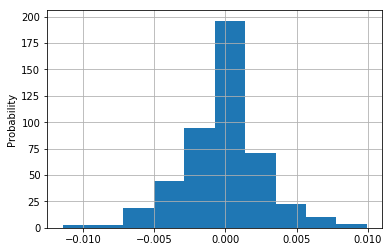

C:\Users\tamar\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


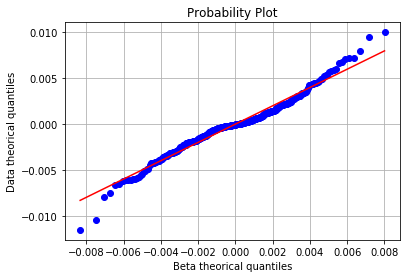

In [33]:
# Pruebas de datos 1
# Ver si son normales
mu1 =np.mean(datos_1)
sigma1 = np.std(datos_1)
# Histograma de las variables creadas
divisiones = 10 # Cantidad de barras en el histograma
plt.hist(datos_1,divisiones,density=True)
plt.ylabel('Probability')
plt.grid()
plt.show()

# gráfica de Q-Q entre las muestras creadas y una curva normal
pr1 = st.beta.fit(datos_1)
grap1 = st.probplot(datos_1,sparams=pr1,  dist="beta", plot=plt)
plt.grid()
plt.xlabel('Beta theorical quantiles')
plt.ylabel('Data theorical quantiles')
plt.show()

In [39]:
param = st.beta.fit(datos_1) # distribution fitting
# param[0] and param[1]
# of the fitted distribution
x = np.linspace(0,60,100)
# fitted distribution
pdf_fitted = st.beta.pdf(x,a=param[0], b=param[1], loc=param[2],scale=param[3])


plt.title('Distribucion normal')
plt.plot(x,pdf_fitted,'r-',label='Fitted')
plt.legend()
plt.hist(datos_1,bins=60,normed=1,alpha=.8,)
plt.show()
print('a fitted = ',param[0],', b fitted = ',param[1])


C:\Users\tamar\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


TypeError: _parse_args() missing 2 required positional arguments: 'a' and 'b'

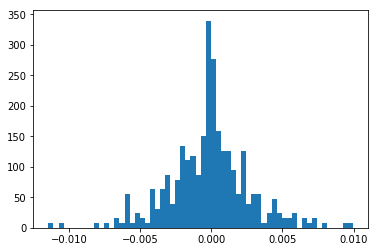

In [35]:
J = 60 # Cantidad de particiones del histograma bins=60
[freq_1,x1,p]=plt.hist(datos_1,J,density=True)
plt.show()
# Se obvia el último valor de x para obtener exactamente J muestras de x
x1 = x1[:-1] 

In [36]:
pi = st.beta.pdf(x1,a=param[0], b=param[1], loc=param[2],scale=param[3])
# Cálculo de la esperanza usando la expresión teórica
Ei = x1*pi
# Cálculo teórico de la chi cuadrada
x2 = np.sum(list(map(lambda Ei,obs_i:(obs_i-Ei)**2/Ei,Ei,freq_1)))
print('Valor de chi cuadrado teorico  = ',x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(freq_1,Ei)
print('Valor de chi cuadrado librería = ',X2)

# Cálculo de Grados de libertad del estadístico
p = 2 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q = 0.95,df=m)
print('Estadístico de chi_cuadrado = ',Chi_est)

Valor de chi cuadrado teorico  =  -14694503.927850928
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=-14694503.927850928, pvalue=1.0)
Estadístico de chi_cuadrado =  75.62374846937608


In [18]:
a=param[0]
b = param[1]

In [38]:
N = []
N = np.random.beta(a, b,10000) 
precio= np.mean(N)
precio

0.5042991110673732

In [24]:
df_pe

,TimeStamp,Open,High,Low,Close
0,2018-12-31 21:00:00,1.14562,1.14682,1.14562,1.14649
1,2019-01-01 21:00:00,1.14649,1.14970,1.13250,1.13458
2,2019-01-02 21:00:00,1.13458,1.14112,1.13091,1.13984
3,2019-01-03 21:00:00,1.13980,1.14190,1.13458,1.14030
4,2019-01-04 21:00:00,1.14035,1.14036,1.13950,1.13951
5,2019-01-06 21:00:00,1.13974,1.14827,1.13972,1.14770
6,2019-01-07 21:00:00,1.14770,1.14848,1.14219,1.14406
7,2019-01-08 21:00:00,1.14405,1.15584,1.14364,1.15544
8,2019-01-09 21:00:00,1.15548,1.15702,1.14846,1.14980
9,2019-01-10 21:00:00,1.14982,1.15406,1.14582,1.14628


In [23]:
mu = np.mean(eurusdAC)
sigma = np.std(eurusdAC)
N = []
for i in range (1,10000):
    N = np.random.normal(mu, sigma,i) 
precio= np.mean(N)
precio

1.117568881872746